In [ ]:
import pandas as pd
import numpy as np

This notebook roughly investigates if Factor Analysis can correctly find genes in the k = 1 pathway that **DICER1** participates in.

# Preparing the data for analysis

Loading main gene dependency data:

In [2]:
df_gene_effect = pd.read_csv("preprocessed_data/20Q4v2_Achilles_gene_effect.csv")

df_gene_effect.head()

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000004,0.181332,0.089101,-0.193867,-0.024587,0.038458,-0.181824,0.351672,-0.440073,0.292582,...,-0.124218,-0.469306,NaN,NaN,0.257361,0.244834,-0.408512,0.284734,0.226412,-0.149566
1,ACH-000005,-0.076383,0.245190,0.191238,0.153008,-0.197035,-0.323295,0.252522,-0.571498,-0.068945,...,-0.212442,-0.426151,-0.068295,0.031635,0.205469,-0.068536,-0.092858,0.074640,0.028779,-0.264840
2,ACH-000007,0.102195,0.092449,-0.045926,0.171892,0.140561,0.170971,0.086060,-0.432320,0.010664,...,-0.083183,-0.269196,0.101146,0.277820,0.208814,0.001393,-0.327514,0.048714,-0.372854,-0.433157
3,ACH-000009,0.142342,-0.033126,-0.051224,0.060560,0.116002,-0.010044,0.104725,-0.610481,0.181508,...,-0.277264,-0.307018,0.044741,0.201551,0.083866,0.052208,-0.574719,0.218682,-0.074750,-0.551760
4,ACH-000011,0.280082,0.088898,0.032321,0.446598,-0.037188,-0.228207,0.110942,-0.406541,0.153979,...,-0.385241,-0.476314,-0.000984,0.013225,0.294002,0.137939,-0.245951,0.111173,-0.227417,-0.349564


DICER1 correlation data:

In [3]:
df_correlations = pd.read_csv("preprocessed_data/corr_DICER1_preprocessed.csv", delimiter=";")

df_correlations[:10]

,gene_selected,gene_evaluated,corr,pvalue,rank,is_on_pathway
0,DICER1,DICER1,1,Inf,1,1
1,DICER1,XPO5,"0,503616844","52,45448018",2,1
2,DICER1,DROSHA,"0,33792351","22,30645548",3,1
3,DICER1,AGO2,"0,329596473","21,20102211",4,1
4,DICER1,ANKRD52,"0,298301131","17,34229262",5,1
5,DICER1,DGCR8,"0,281137304","15,41695831",6,1
6,DICER1,DOLK,"0,243667755","11,65924734",7,0
7,DICER1,MNAT1,"0,210099516","8,665429172",8,0
8,DICER1,MAP4K4,"-0,208073683","8,627124342",9,0
9,DICER1,RBSN,"0,207383078","8,573272881",10,0


In [4]:
# TODO: Consider making gene selection even easier?

number_of_genes = 20 # Should be an even number
assert(number_of_genes % 2 == 0)
selected_columns = pd.concat([df_correlations["gene_evaluated"][:number_of_genes // 2], df_correlations["gene_evaluated"][-number_of_genes // 2:]]).to_list()
selected_columns = tuple(selected_columns)
selected_columns, len(selected_columns)

(('DICER1',
  'XPO5',
  'DROSHA',
  'AGO2',
  'ANKRD52',
  'DGCR8',
  'DOLK',
  'MNAT1',
  'MAP4K4',
  'RBSN',
  'RHAG',
  'STAT6',
  'JAG1',
  'HIRIP3',
  'NAT1',
  'ZSCAN22',
  'PCDHB16',
  'ORMDL2',
  'HYOU1',
  'BTG1'),
 20)

In [5]:
columns_of_interest = [column for column in df_gene_effect.columns if column.split(" ")[0] in selected_columns]
assert(len(selected_columns) == len(columns_of_interest)) # Rough automatic check for whether we found all corresponding columns in gene_effect dataset that we've selected.
columns_of_interest, len(columns_of_interest)

(['AGO2 (27161)',
  'ANKRD52 (283373)',
  'BTG1 (694)',
  'DGCR8 (54487)',
  'DICER1 (23405)',
  'DOLK (22845)',
  'DROSHA (29102)',
  'HIRIP3 (8479)',
  'HYOU1 (10525)',
  'JAG1 (182)',
  'MAP4K4 (9448)',
  'MNAT1 (4331)',
  'NAT1 (9)',
  'ORMDL2 (29095)',
  'PCDHB16 (57717)',
  'RBSN (64145)',
  'RHAG (6005)',
  'STAT6 (6778)',
  'XPO5 (57510)',
  'ZSCAN22 (342945)'],
 20)

In [6]:
X = df_gene_effect[columns_of_interest].dropna() # Is dropping rows with na a good idea? Maybe use mean value instead?
X = X.to_numpy()
if 808 - X.shape[0] > 0:
    print(f"Warning: {808 - X.shape[0]} rows contained at least 1 NA and was dropped.")
X.shape

(796, 20)

# Analysis

In [7]:
import sys
import os

# Get the current working directory (where the notebook is running)
notebook_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you can import your module
from utils import factor_model_solution, factor_goodness_of_fit_test

In [8]:
_, lambda_hat = factor_model_solution(X, k = 1)
lambda_hat

array([[-0.46006248],
       [-0.43950578],
       [ 0.0853125 ],
       [-0.32229552],
       [-0.78339134],
       [-0.28554635],
       [-0.4212857 ],
       [ 0.13032313],
       [-0.14649522],
       [-0.1262754 ],
       [ 0.19442815],
       [-0.23221741],
       [ 0.12352559],
       [ 0.13787435],
       [-0.08899356],
       [-0.29076869],
       [-0.14821865],
       [ 0.10028168],
       [-0.64101898],
       [-0.09776291]])

In [11]:
loadings = lambda_hat.T[0] # Extract loadings as a list

# Extract gene names (everything before the space)
genes = [column.split(" ")[0] for column in columns_of_interest]

# Create a DataFrame from genes and values
df_values = pd.DataFrame({
    'gene_evaluated': genes,
    'loadings': loadings
})

# Merge with df_correlations on 'gene'
merged_df = df_values.merge(df_correlations[['gene_evaluated', 'is_on_pathway']], on='gene_evaluated', how='left')

print(merged_df.sort_values("loadings", ascending=True))


   gene_evaluated  loadings  is_on_pathway
4          DICER1 -0.783391              1
18           XPO5 -0.641019              1
0            AGO2 -0.460062              1
1         ANKRD52 -0.439506              1
6          DROSHA -0.421286              1
3           DGCR8 -0.322296              1
15           RBSN -0.290769              0
5            DOLK -0.285546              0
11          MNAT1 -0.232217              0
16           RHAG -0.148219              0
8           HYOU1 -0.146495              0
9            JAG1 -0.126275              0
19        ZSCAN22 -0.097763              0
14        PCDHB16 -0.088994              0
2            BTG1  0.085313              0
17          STAT6  0.100282              0
12           NAT1  0.123526              0
7          HIRIP3  0.130323              0
13         ORMDL2  0.137874              0
10         MAP4K4  0.194428              0


We get heavier loadings on genes that actually lie on the pathway!!

In [10]:
factor_goodness_of_fit_test(X, k = 1)

4.191027767126529e-31

Test shows that k = 1 **is not** sufficient to describe (**all**) the data. But sufficient to **only** capture the (single) pathway perhaps?

In [43]:
len(merged_df)

20

([], [])

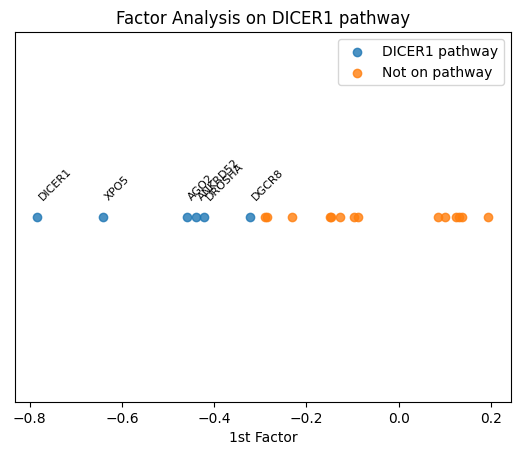

In [69]:
import matplotlib.pyplot as plt

for category_num, label in [(1, "DICER1 pathway"), (0, "Not on pathway")]:
    subset = merged_df[merged_df['is_on_pathway'] == category_num]
    plt.scatter(subset['loadings'], np.zeros(len(subset)), label=label, alpha=0.8)

    if category_num == 0:
        continue
    for _, row in subset.iterrows():
        plt.text(row['loadings'], 0.005, row['gene_evaluated'], 
                 fontsize=8, alpha=1, rotation=45)

plt.title("Factor Analysis on DICER1 pathway")
plt.legend()
plt.xlabel("1st Factor")
plt.yticks([])